In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pickle as pkl
import scipy.signal as signal
from scipy.interpolate import griddata
from matplotlib import colors
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import minimize

In [2]:
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

(13, 1024)


### A note on error bars:

In this notebook I use errors generated from the fitting processes themselves. One of these methods involves using the inverse Hessian of the log likelihood function, which is similar to the method of taking 2nd derivatives of the log likelihood function, a popular method of finding error bars. Errors can also be generated by bootstapping, of course!

# 1) Find all 100-day period signals. Measure the amplitude and amplitude error on these signals.

The approach here is simple: just subtract off the mean signal to remove any bias. Then follow the fitting procedure described in my HW1 solution.

The model used here is $y(x) = C_1\cos(\omega x)+C_2\sin(\omega x)$ where $\omega = \frac{2\pi}{100}$ (we're looking for a 100 day period signal).

Note that this model is equivalent to $A\sin(\omega x+\phi) = A\cos(\omega x)\sin(\phi)+A\cos(\phi)\sin(\omega x)$ with $C_1 = \sin(\phi)$ and $C_2 = \cos(\phi)$.

Then $A = \sqrt{(C_1^2+C_2^2)}$.

To get the error on $A$, I propograte the $C_1$ and $C_2$ errors.

The results of this procedure are pretty reasonable. Based on these fits, it looks like Data Sets 4, 5, 6, 9, 10 and 11 all have 100 day sinusoidal signals. I made this judgement because all of these data sets have a signal to noise ratio of greater than 5 for the 100 day period signal.

In [3]:
def model1(x, C1, C2):
    omega = 2*np.pi/100
    return C1*np.cos(omega*x)+C2*np.sin(omega*x)

In [4]:
def model1_fit(data_xs, data_ys, data_sigma_ys):
    omega = 2*np.pi/100
    X = np.vstack((np.cos(omega*data_xs), np.sin(omega*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)

    #fit variance
    A = (X.T@C_inv)@X
    B = np.identity(A.shape[0])
    Z_var = linalg.solve(A, B)
    
    #unpack data
    C1 = Z[0][0]
    C1_err = np.sqrt(Z_var[0][0])  
    C2 = Z[1][0]
    C2_err = np.sqrt(Z_var[1][1])
    #print(f'The uncertainty variance of the amplitude is {C1_err**2}')
    return C1, C1_err, C2, C2_err

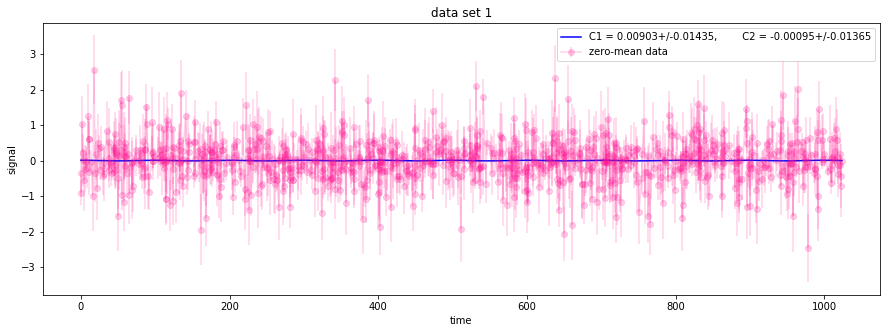

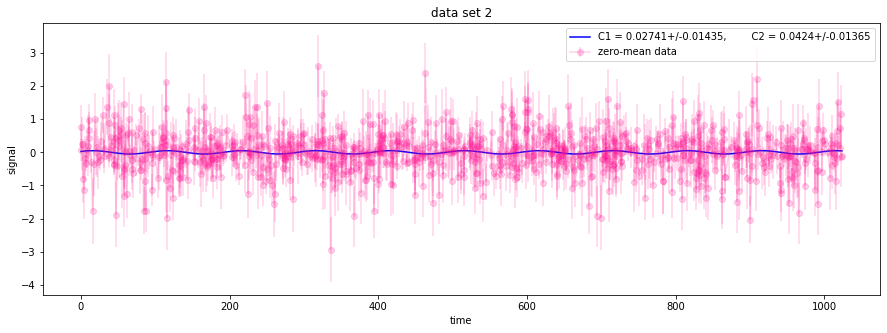

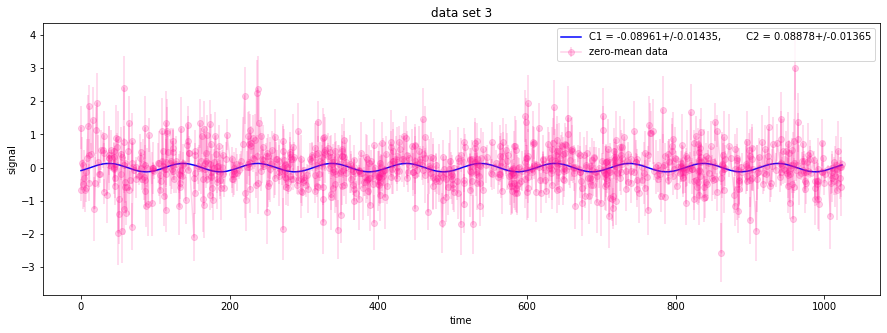

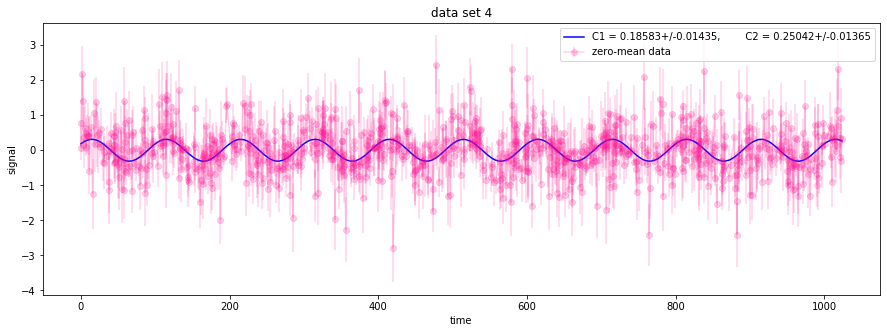

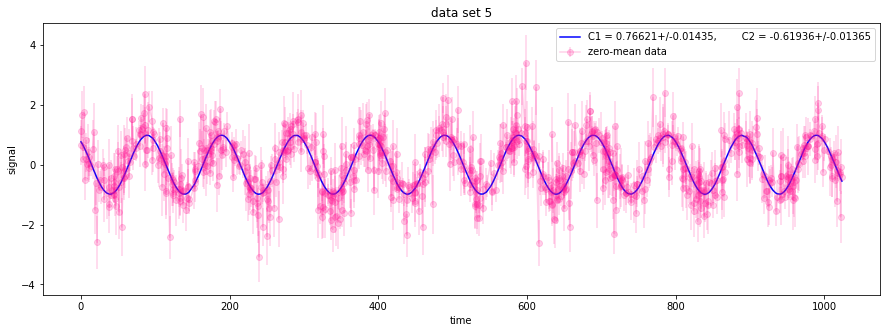

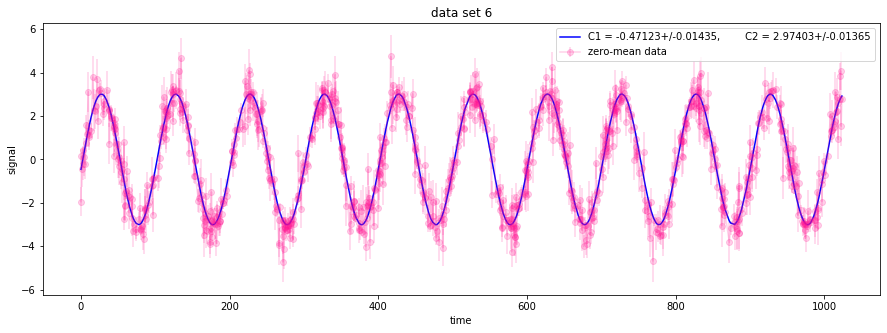

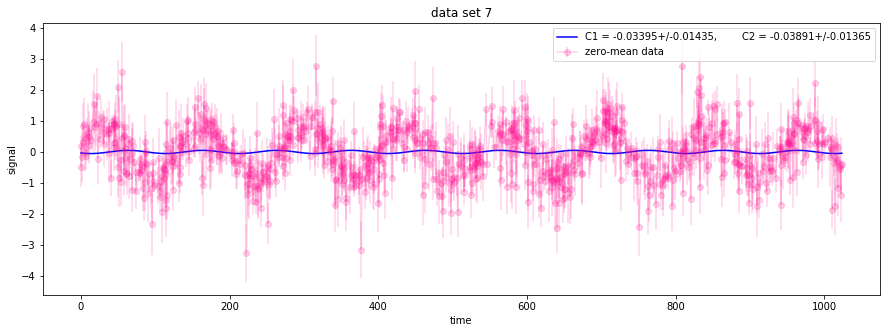

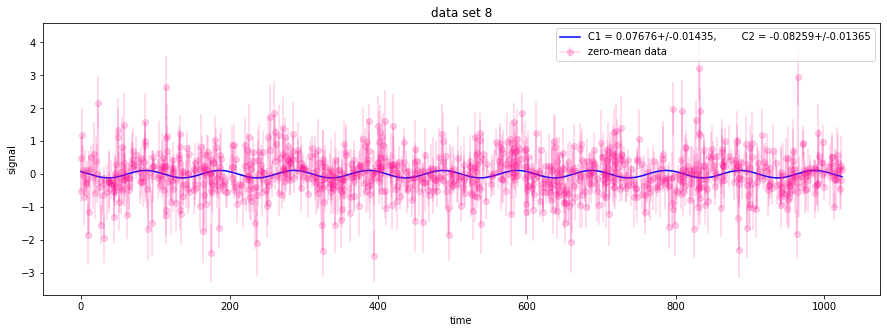

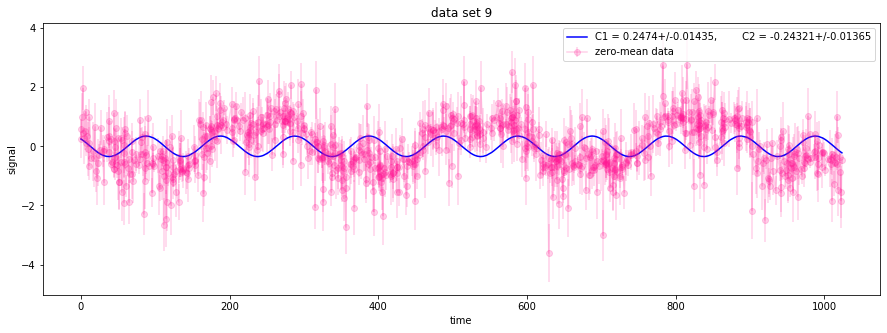

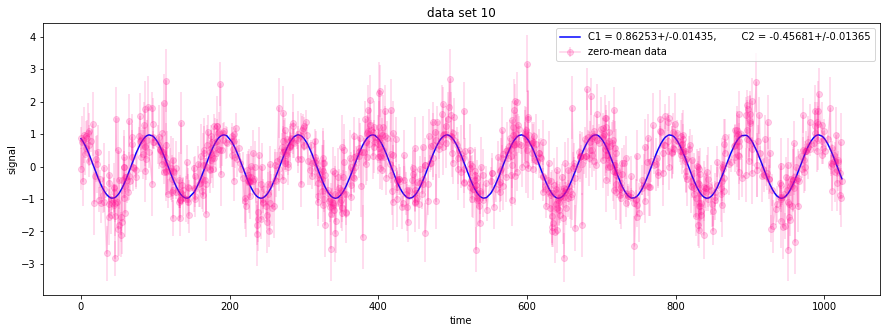

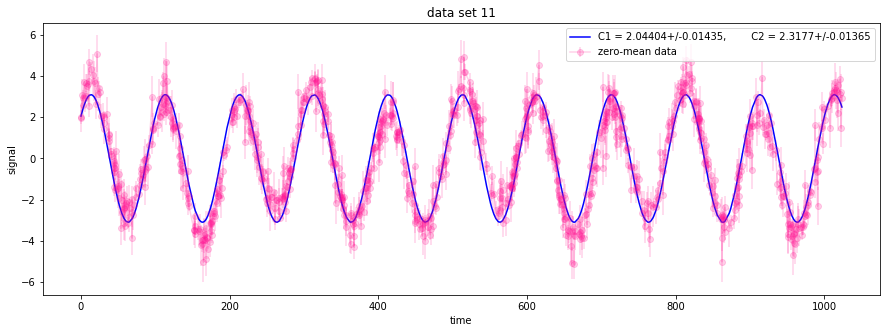

In [5]:
# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.

xs = data[0]
yerrs = data[1]

C1s = []
C2s = []
C1_errs = []
C2_errs = []

for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    ys = data[i]-np.mean(data[i])
    C1, C1_err, C2, C2_err = model1_fit(xs, ys, yerrs)
    plt.errorbar(data[0], ys, yerr=data[1],
                 color="deeppink", marker="o", alpha=0.2, label = 'zero-mean data')
    plt.plot(xs, model1(xs, C1, C2), color = 'blue', label = f'C1 = {np.around(C1,5)}+/-{np.around(C1_err,5)},\
        C2 = {np.around(C2,5)}+/-{np.around(C2_err,5)}')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.legend()
    plt.title("data set {}".format(i-1))
    C1s.append(C1)
    C2s.append(C2)
    C1_errs.append(C1_err)
    C2_errs.append(C2_err)
C1s = np.array(C1s)
C2s = np.array(C2s)
C1_errs = np.array(C1_errs)
C2_errs = np.array(C2_errs)

In [6]:
#propograte the errors
err_C1_2s = 2*C1_errs*C1s
err_C2_2s= 2*C2_errs*C2s
err_C1_sum_C2_2s = np.sqrt((err_C1_2s)**2+(err_C2_2s)**2)
A_errs = 0.5*err_C1_sum_C2_2s/np.sqrt(err_C1_sum_C2_2s)

Text(0, 0.5, '100 day period signal amplitude')

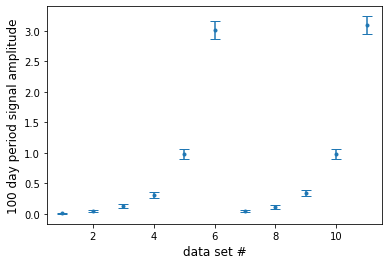

In [7]:
#C1 = Asin(phi)
#C2 = Acos(phi)
#A = np.sqrt(C1**2+C2**2)
#error_A = propogate the error!
plt.errorbar(np.arange(1, len(C1s)+1), np.sqrt(C1s**2+C2s**2), yerr = A_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5)
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('100 day period signal amplitude', fontsize = 12)

Text(0, 0.5, '100 day period SNR')

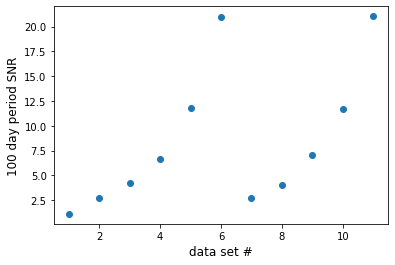

In [8]:
plt.plot(np.arange(1, len(C1s)+1), np.sqrt(C1s**2+C2s**2)/A_errs, linestyle = 'None', marker = 'o')
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('100 day period SNR', fontsize = 12)

# 2) Find other signals

Finding other signals in the data is a bit more complicated. Below I've taken Lomb-Scargle periodograms for each data set. LS periodograms are a bit like FFTs but for unevenly space data points. I then select the to 2 dominant frequencies to do further analysis with.

Because we will be fitting to signals with 2 frequencies, we'll need another model:

$y(x) =  A_1\cos(\omega_1x)+A_2\sin(\omega_1x)+B_1\cos(\omega_2x)+B_2\sin(\omega_2x)$

Another way to do this is through brute force: choose a range of possible periods for the second signal. For each period value, do the original, linear fit and then save the log likelihood function using the optimal parameters found. Then plot the log likelihood vs period plot and find the minimum to find the period!

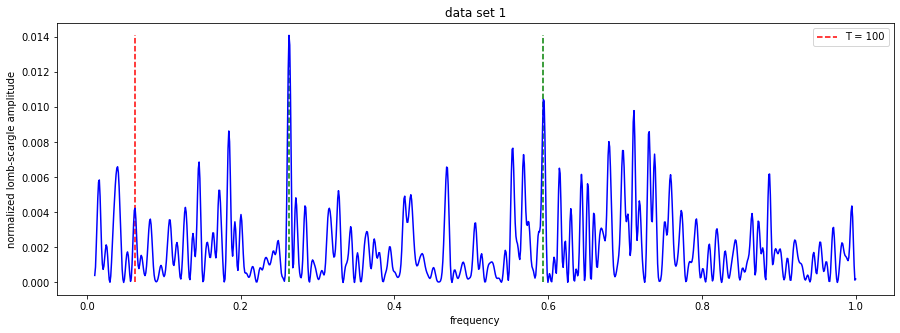

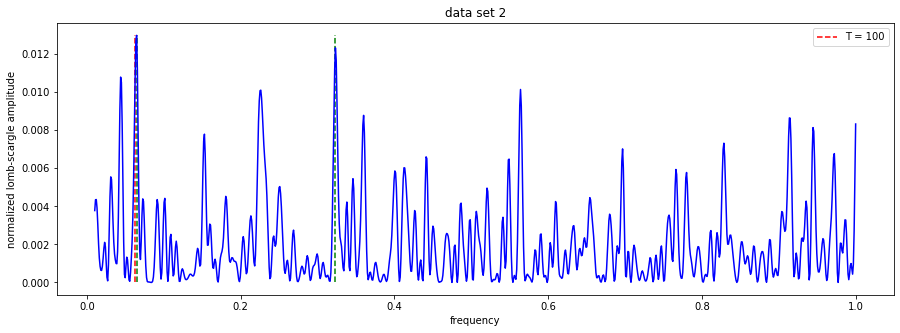

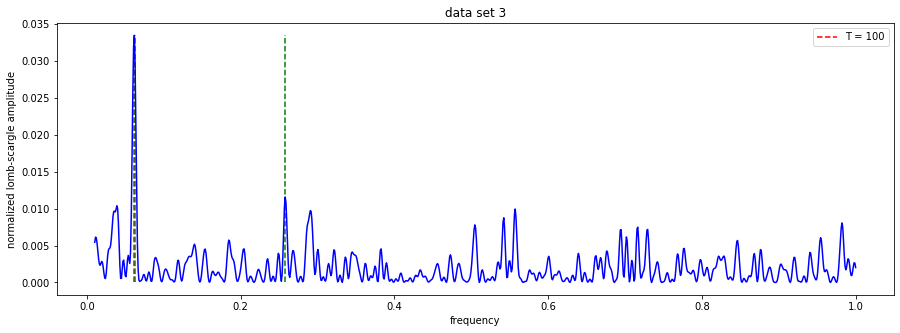

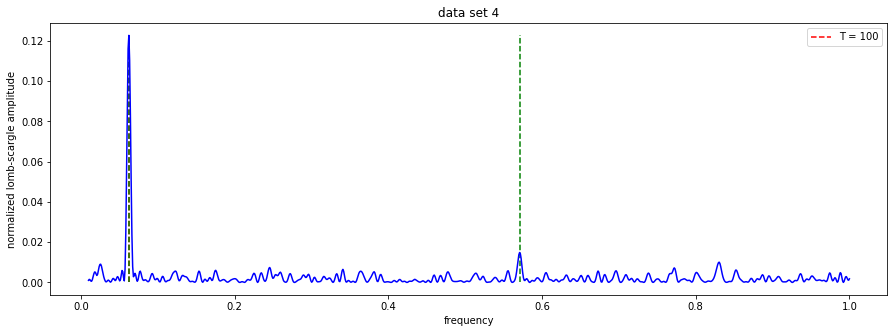

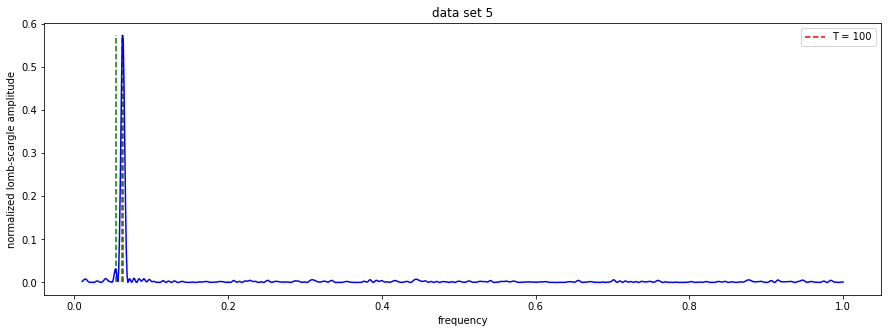

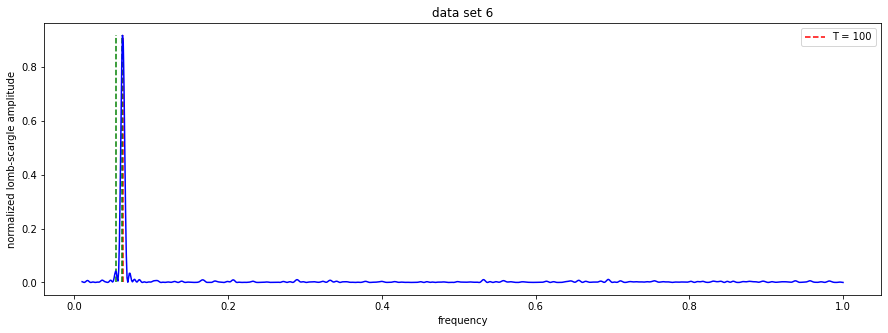

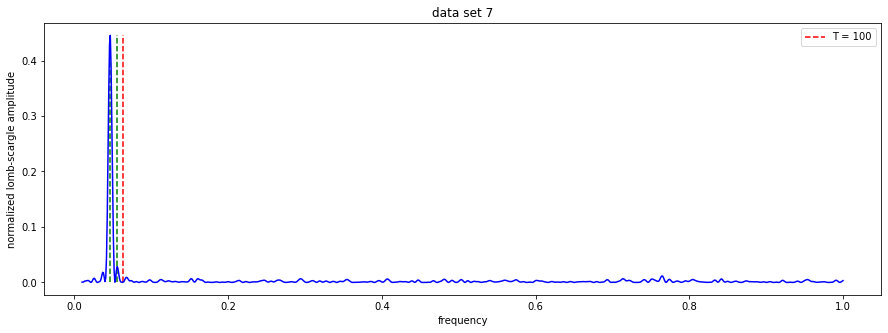

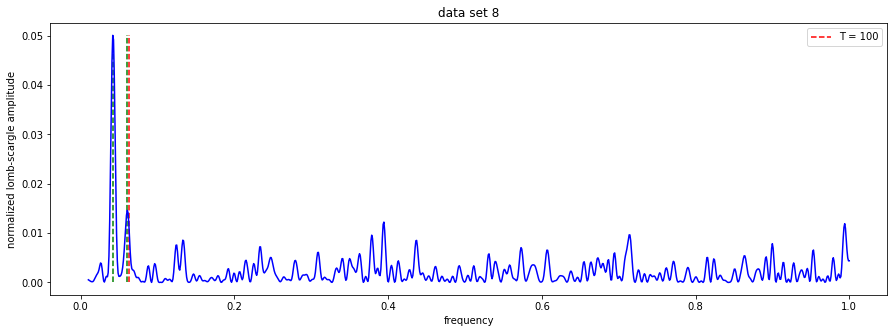

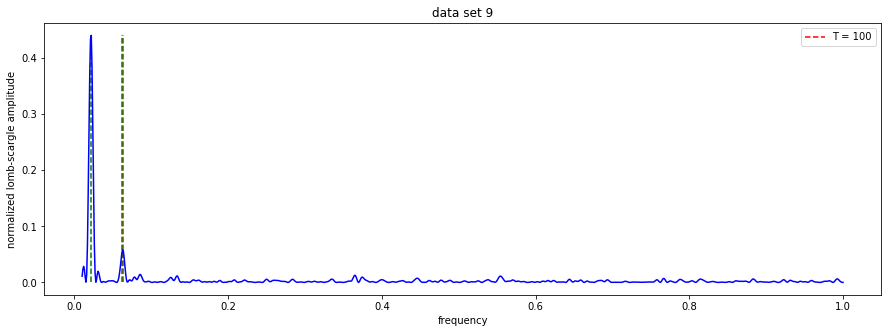

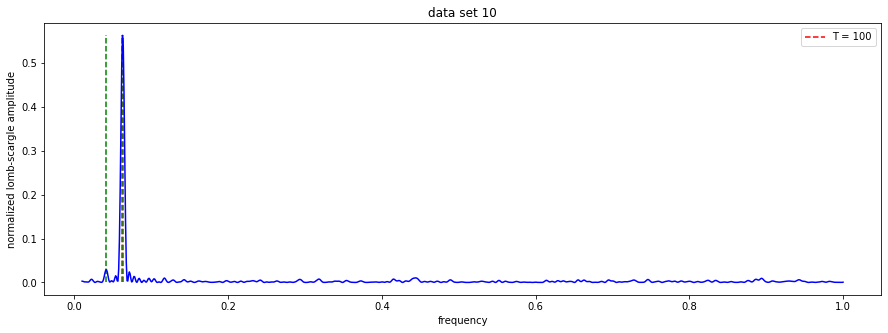

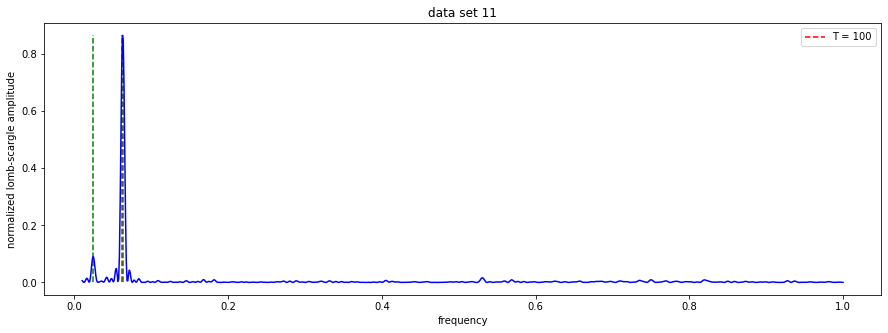

In [9]:
peak_omegas_list = []
for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    ys = data[i]-np.mean(data[i])
    nout = 1000
    omega = 2*np.pi/100
    w = np.linspace(0.01, 1, nout)
    pgram = signal.lombscargle(xs, ys, w, normalize=True)
    plt.plot(w, pgram, color = 'blue')
    plt.vlines(omega, 10**-6, np.max(pgram), color = 'red', linestyle = '--', label = 'T = 100')
    plt.xlabel("frequency")
    plt.ylabel("normalized lomb-scargle amplitude")
    plt.legend()
    plt.title("data set {}".format(i-1))
    #maxomega_args = np.argsort(pgram)[::-1]
    #maxomegas = w[maxomega_args]
    #maxomegas_list.append(maxomegas)
    peaks, _ = find_peaks(pgram)
    sort = np.argsort(pgram[peaks])[::-1]
    peak_inds = peaks[sort]
    peak_omegas = w[peak_inds][:2]
    for peak_omega in peak_omegas:
        plt.vlines(peak_omega, 10**-6, np.max(pgram), color = 'green', linestyle = '--', label = 'T = 100')
    peak_omegas_list.append(peak_omegas)
    
    

In [10]:
def model2(x, A1, A2, B1, B2, omega1, omega2):
    func = A1*np.cos(omega1*x)+A2*np.sin(omega1*x)+B1*np.cos(omega2*x)+\
            B2*np.sin(omega2*x)
    return func

### Using optimization routines: scipy.optimize.minimize

Below I use scipy minimization routines, although the matrix method below is much more reliable. I follow the same methodology as in the first part: subtract off the mean of each signal, and fit it to my model. This time, the model has 2 frequencies. These 2 frequencies are the 2 dominant frequencies from the periodograms above for each data set. 

I implement a method of finding the error of estimated parameters using scipy.optimize.minimize, see https://stackoverflow.com/questions/43593592/errors-to-fit-parameters-of-scipy-optimize

Here is a quote from the above stack overflow source:

"The documentation for this scipy.optimize.minimize says

    The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol.

Roughly speaking, the minimization stops when the value of the function f that you're minimizing is minimized to within ftol of the optimum. (This is a relative error if f is greater than 1, and absolute otherwise; for simplicity I'll assume it's an absolute error.) In more standard language, you'll probably think of your function f as a chi-squared value. So this roughly suggests that you would expect

$\chi^2_{\mathrm{found}} - \chi^2_{\mathrm{optimal}} \lesssim \mathtt{ftol}$

Of course, just the fact that you're applying a minimization routine like this assumes that your function is well behaved, in the sense that it's reasonably smooth and the optimum being found is well approximated near the optimum by a quadratic function of the parameters xi:

$\chi^2_{\mathrm{found}} - \chi^2_{\mathrm{optimal}} \approx \sum_{i,j} H_{ij} \Delta x^i \Delta x^j$

where Δxi is the difference between the found value of parameter xi and its optimal value, and Hij is the Hessian matrix. A little (surprisingly nontrivial) linear algebra gets you to a pretty standard result for an estimate of the uncertainty in any quantity X that's a function of your parameters xi:

$(\Delta X)^2 = \left(\chi^2_{\mathrm{found}} - \chi^2_{\mathrm{optimal}}\right) \sum_{i,j} \left(H^{-1}\right)_{ij} \frac{\partial X}{\partial x^i} \frac{\partial X}{\partial x^j}$

which lets us write

$(\Delta X)^2 \lesssim \mathtt{ftol} \sum_{i,j} \left(H^{-1}\right)_{ij}\frac{\partial X}{\partial x^i}\frac{\partial X}{\partial x^j}$

That's the most useful formula in general, but for the specific question here, we just have X = xi, so this simplifies to

$\Delta x^i \lesssim \sqrt{\mathtt{ftol} \left(H^{-1}\right)_{ii}}$

Finally, to be totally explicit, let's say you've stored the optimization result in a variable called res. The inverse Hessian is available as res.hess_inv, which is a function that takes a vector and returns the product of the inverse Hessian with that vector."

Concerning the above error estimation, I am not completely convinced that it estimates the error well enough to use it in my own research. It looks like this method underestimates the error considerably compared to the matrix method. If I was analyzing this data for a paper, I would just use bootstrap! But it was cool to try this method because you only have to run the optimization once, and in theory I think it should work.

The resulting fits look decent. It looks like Data Sets 3, 4, 5, 6, 9, 10, and 11 all have 100 day period signal components. The signal to noise ratios look suspiciously large for all data sets, so it's possible the error quantification method is not ideal.

### A WARNING: If you try to use scipy.optimize.minimize to fit nonlinear stuff, you will be very unhappy! Always try to recast fitting problems as linear, using profiling if necessary.

Additionally, JAX is a good library for taking derivatives, if you prefer it to using a scipy optimizer.

In [11]:
def log_likelihood(params,  C_inv = 1/yerrs**2, xs = xs, ys=ys, omegas = [1,1]):
    yhats = model2(xs, *params,*omegas)
    residuals = (ys-yhats)
    arr = -0.5*C_inv**2*residuals**2
    ll = np.sum(arr)
    return -ll
    

In [12]:
def minimize_fit2(yerrs, xs, ys, omegas):
    initParams = [1,1,1,1]
    ftol = 2.220446049250313e-09 #the default value
    results = minimize(log_likelihood, initParams, method='L-BFGS-B', \
                   args = (1/yerrs**2, xs, ys, omegas), \
                       bounds = [(0, None),(0, None), (0, None), (0, None)])
    tmp_i = np.zeros(len(results.x))
    uncertainties = []
    for i in range(len(results.x)):
        tmp_i[i] = 1.0
        hess_inv_i = results.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(results.fun)) * ftol * hess_inv_i)
        tmp_i[i] = 0.0
        uncertainties.append(uncertainty_i)
    return results.x, np.array(uncertainties)

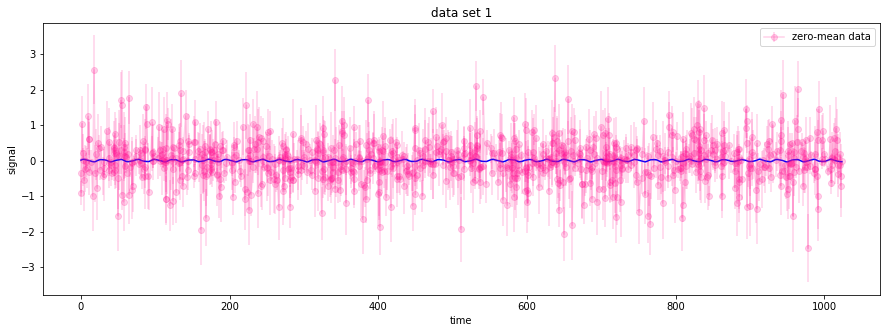

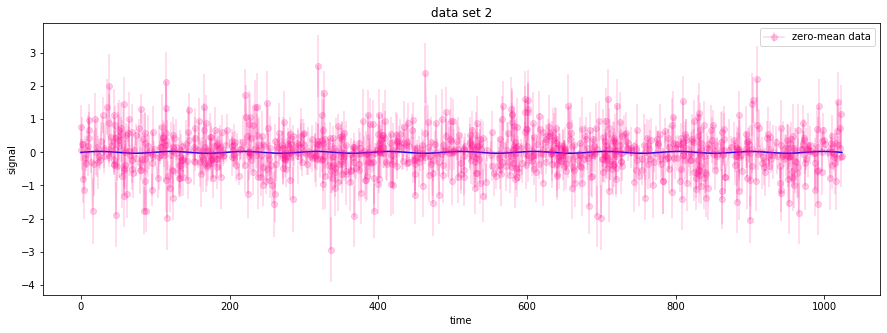

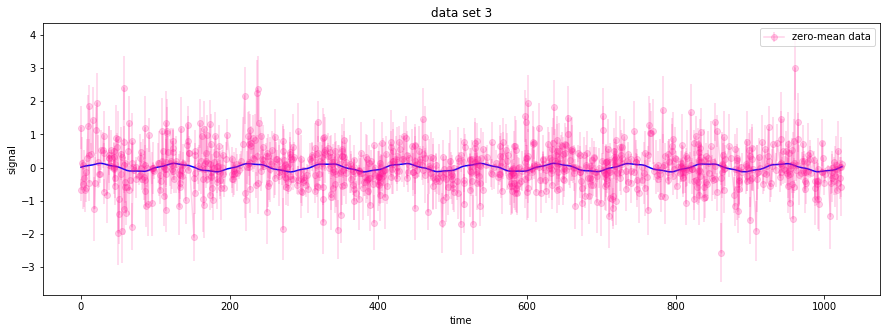

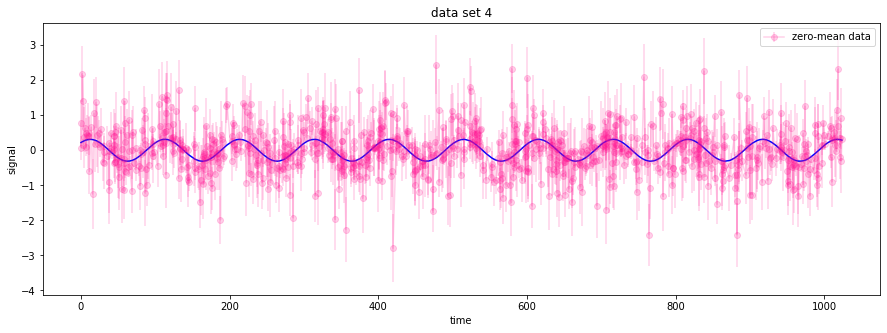

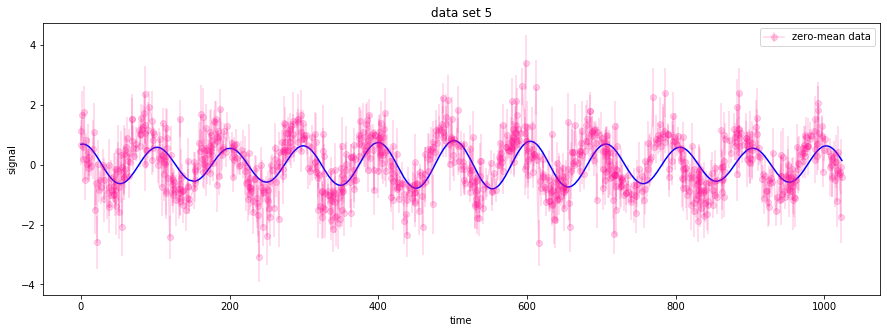

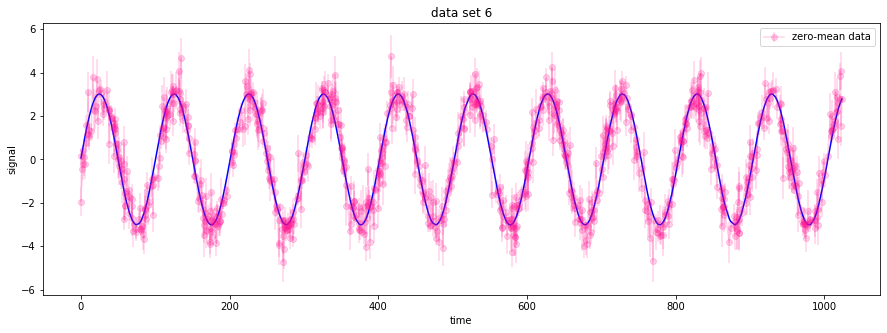

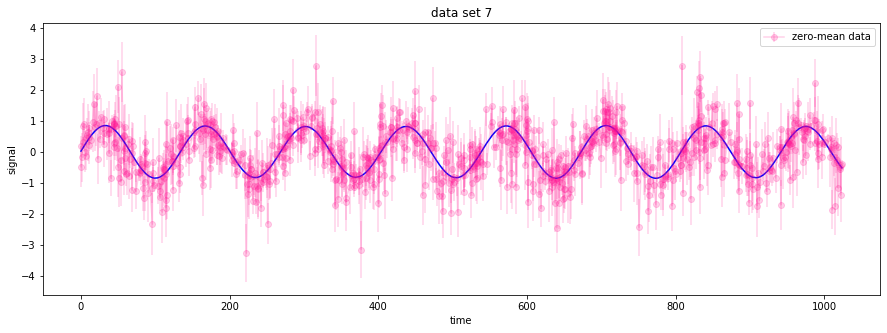

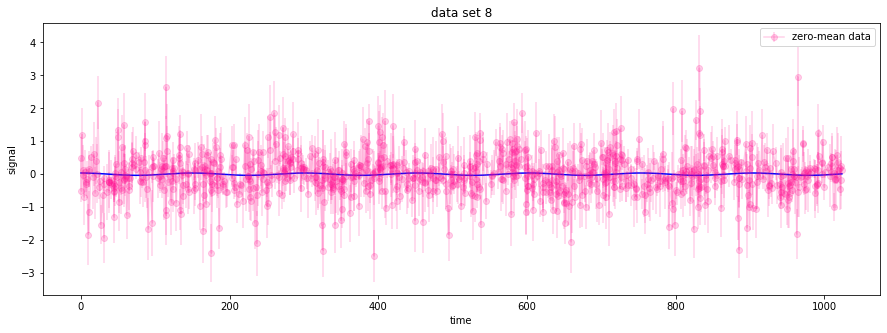

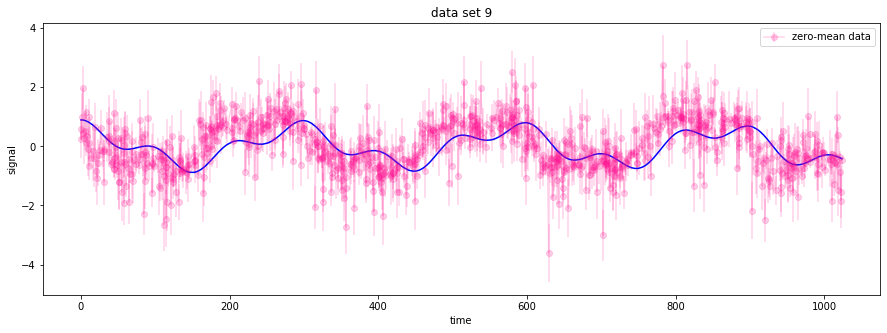

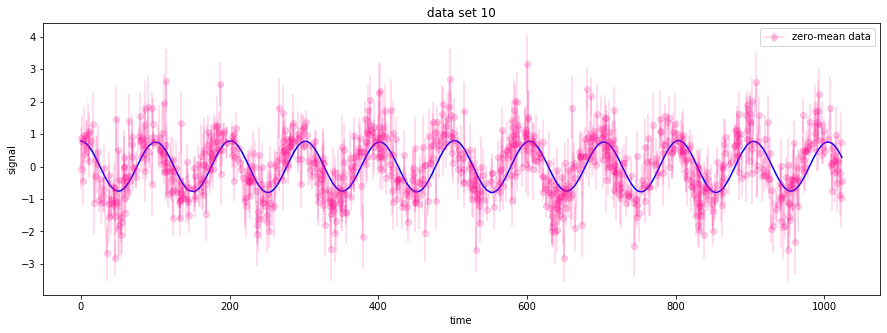

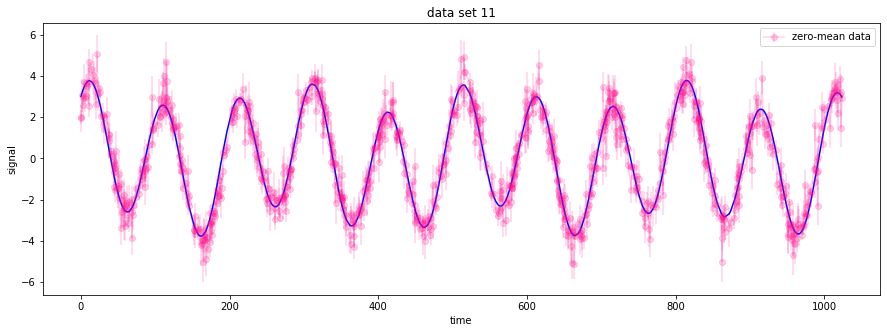

In [13]:
xs = data[0]
yerrs = data[1]

params_list = []
errors_list = []

for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    ys = data[i]-np.mean(data[i])
    omegas = (peak_omegas_list[i-2]).tolist()
    params, errors = minimize_fit2(yerrs, xs, ys, omegas)
    plt.errorbar(xs, ys, yerr=yerrs,
                 color="deeppink", marker="o", alpha=0.2, label = 'zero-mean data')
    plt.plot(xs, model2(xs,*params,*omegas), color = 'blue')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.legend()
    plt.title("data set {}".format(i-1))
    params_list.append(params)
    errors_list.append(errors)

In [14]:
def calc_error(C1s, C2s, C1_errs, C2_errs):
    err_C1_2s = 2*C1_errs*C1s
    err_C2_2s= 2*C2_errs*C2s
    err_C1_sum_C2_2s = np.sqrt((err_C1_2s)**2+(err_C2_2s)**2)
    A_errs = 0.5*err_C1_sum_C2_2s/np.sqrt(err_C1_sum_C2_2s)
    return A_errs

In [15]:
params_arr = np.vstack(params_list)
errors_arr = np.vstack(errors_list)
A1s = np.sqrt(params_arr[:,0]**2+params_arr[:,1])
A1_errs = calc_error(params_arr[:,0], params_arr[:,1], errors_arr[:,0], errors_arr[:,1])
A2s = np.sqrt(params_arr[:,2]**2+params_arr[:,3])
A2_errs = calc_error(params_arr[:,2], params_arr[:,3], errors_arr[:,2], errors_arr[:,3])

/home/mia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [16]:
#print the different signal periods. check the signal strength in the SNR plot below.
2*np.pi/np.vstack(peak_omegas_list)

array([[ 23.91747493,  10.58321046],
       [ 97.40692306,  19.44336686],
       [102.11326048,  24.37726561],
       [100.49475059,  11.00573724],
       [100.49475059, 117.2157259 ],
       [100.49475059, 117.2157259 ],
       [134.63968515, 113.03623486],
       [150.63360024, 103.78475731],
       [287.00969922, 100.49475059],
       [100.49475059, 150.63360024],
       [100.49475059, 263.1824789 ]])

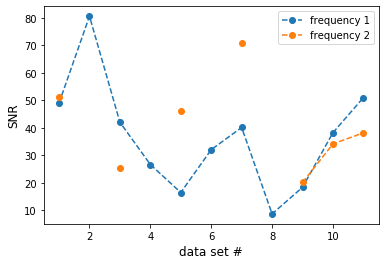

In [17]:
plt.plot(np.arange(1, len(A1s)+1), A1s/A1_errs, 'o', linestyle = '--', label = 'frequency 1')
plt.plot(np.arange(1, len(A2s)+1), A2s/A2_errs, 'o', linestyle = '--', label = 'frequency 2')
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('SNR', fontsize = 12)
plt.legend()

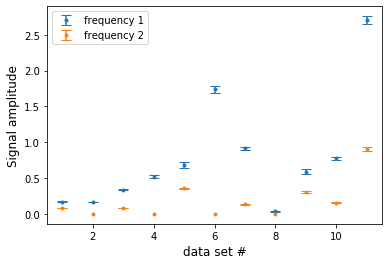

In [18]:
plt.errorbar(np.arange(1, len(A1s)+1), A1s, yerr = A1_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5, label = 'frequency 1')
plt.errorbar(np.arange(1, len(A2s)+1), A2s, yerr = A2_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5, label = 'frequency 2')
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('Signal amplitude', fontsize = 12)
plt.legend()

### Matrix method

Using the fit method from part 1, but with the model $y(x) =  A_1\cos(\omega_1x)+A_2\sin(\omega_1x)+B_1\cos(\omega_2x)+B_2\sin(\omega_2x)$. This method is much better than the scipy.optimize.minimize method. We get more believable signal to noise ratios. 

It looks like data sets 4, 5, 6, 9, 10, and 11 have strong 100 day period signals. The signal to noise ratio for all of these signals is greater than ~5.

In [19]:
# doing it the matrix way:

def model2_fit(data_xs, data_ys, data_sigma_ys, omegas):
    omega1, omega2 = omegas
    X = np.vstack((np.cos(omega1*data_xs), np.sin(omega1*data_xs), np.cos(omega2*data_xs), np.sin(omega2*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)

    #fit variance
    A = (X.T@C_inv)@X
    B = np.identity(A.shape[0])
    Z_var = linalg.solve(A, B)
    
    #unpack data
    A1 = Z[0][0]
    A1_err = np.sqrt(Z_var[0][0])  
    A2 = Z[1][0]
    A2_err = np.sqrt(Z_var[1][1])
    B1 = Z[2][0]
    B1_err = np.sqrt(Z_var[2][2])  
    B2 = Z[3][0]
    B2_err = np.sqrt(Z_var[3][3])
    #print(f'The uncertainty variance of the amplitude is {C1_err**2}')
    return A1, A1_err, A2, A2_err, B1, B1_err, B2, B2_err

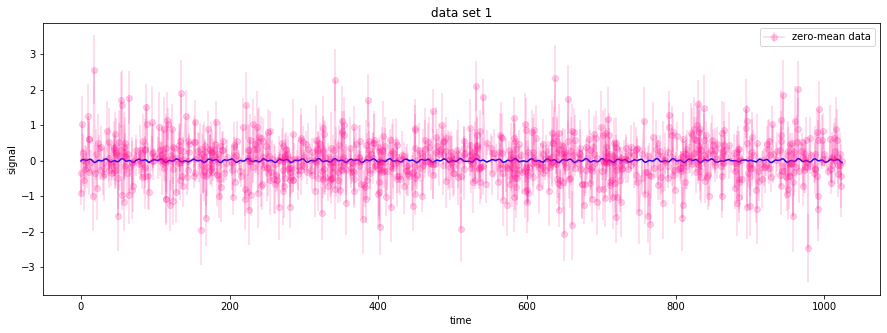

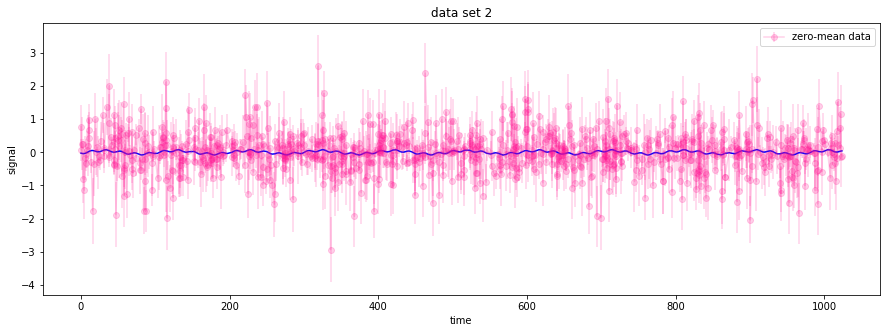

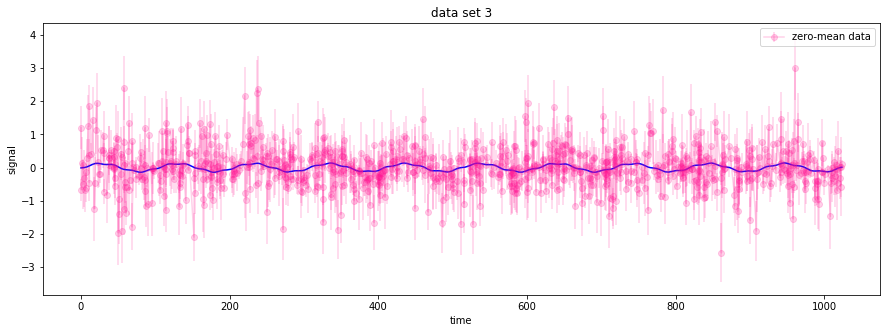

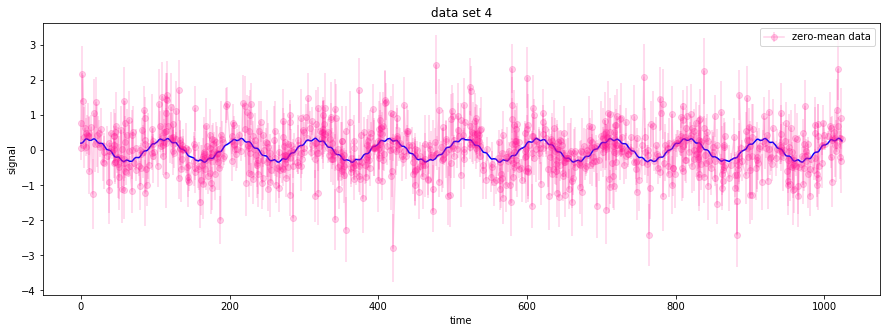

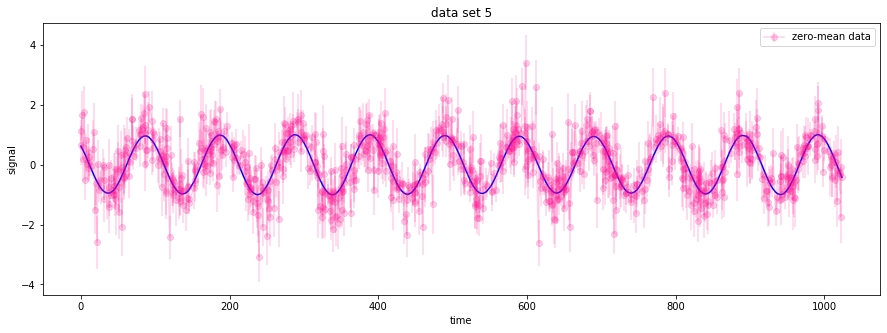

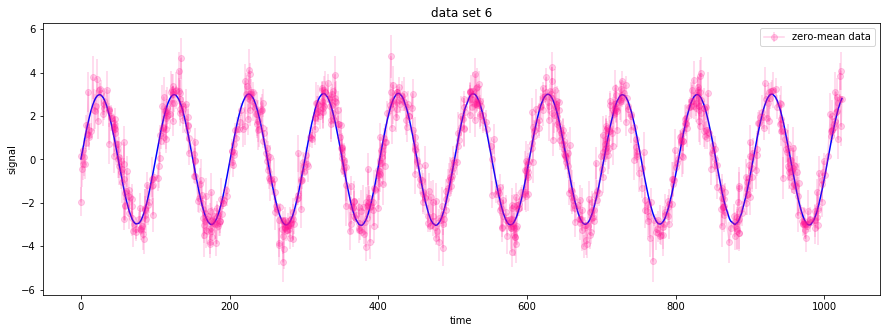

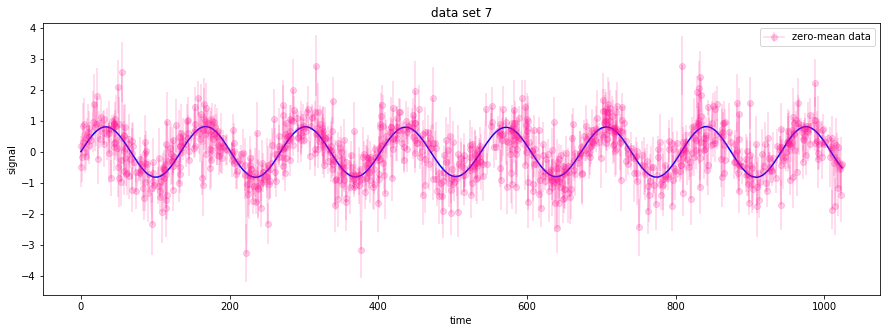

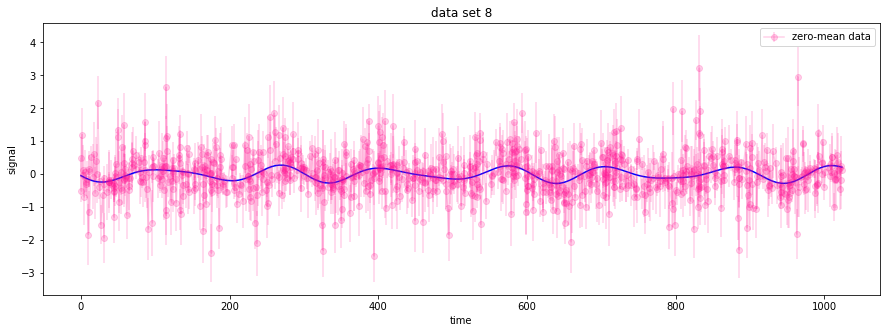

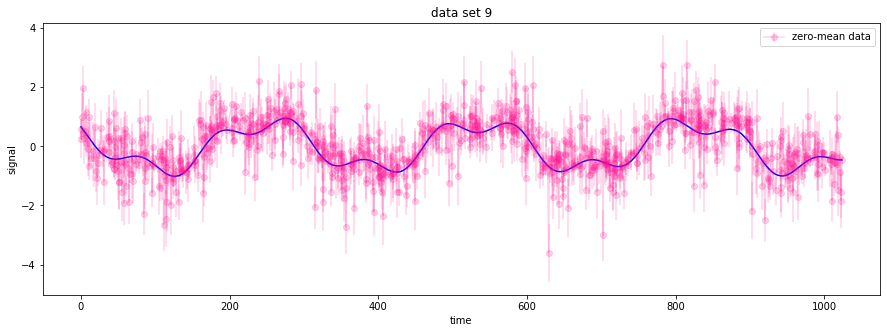

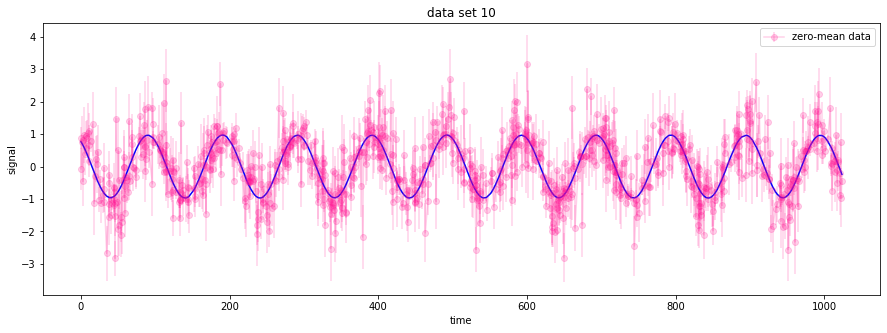

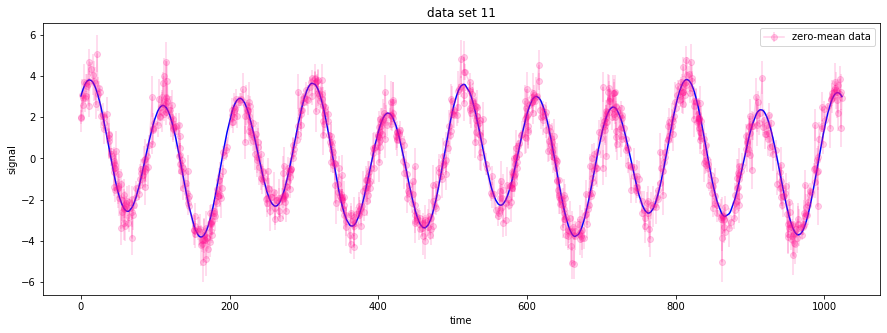

In [20]:
# Dear all:
# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.

xs = data[0]
yerrs = data[1]

B1s = []
B2s = []
C1s = []
C2s = []
B1_errs = []
B2_errs = []
C1_errs = []
C2_errs = []

for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    ys = data[i]-np.mean(data[i])
    omegas = (peak_omegas_list[i-2]).tolist()
    B1, B1_err, B2, B2_err, C1, C1_err, C2, C2_err = model2_fit(xs, ys, yerrs, omegas)
    plt.errorbar(data[0], ys, yerr=data[1],
                 color="deeppink", marker="o", alpha=0.2, label = 'zero-mean data')
    plt.plot(xs, model2(xs, B1, B2, C1, C2, *omegas), color = 'blue')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.legend()
    plt.title("data set {}".format(i-1))
    B1s.append(B1)
    B2s.append(B2)
    B1_errs.append(B1_err)
    B2_errs.append(B2_err)
    C1s.append(C1)
    C2s.append(C2)
    C1_errs.append(C1_err)
    C2_errs.append(C2_err)
B1s = np.array(B1s)
B2s = np.array(B2s)
B1_errs = np.array(B1_errs)
B2_errs = np.array(B2_errs)
C1s = np.array(C1s)
C2s = np.array(C2s)
C1_errs = np.array(C1_errs)
C2_errs = np.array(C2_errs)

In [21]:
#print the different signal periods. check the signal strength in the SNR plot below.
2*np.pi/np.vstack(peak_omegas_list)

array([[ 23.91747493,  10.58321046],
       [ 97.40692306,  19.44336686],
       [102.11326048,  24.37726561],
       [100.49475059,  11.00573724],
       [100.49475059, 117.2157259 ],
       [100.49475059, 117.2157259 ],
       [134.63968515, 113.03623486],
       [150.63360024, 103.78475731],
       [287.00969922, 100.49475059],
       [100.49475059, 150.63360024],
       [100.49475059, 263.1824789 ]])

Text(0, 0.5, 'signal amplitude')

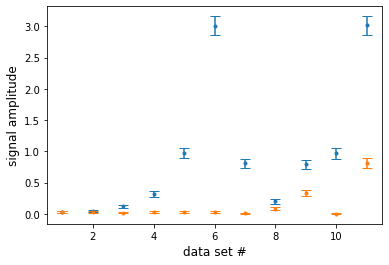

In [22]:
#C1 = Asin(phi)
#C2 = Acos(phi)
#A = np.sqrt(C1**2+C2**2)
#error_A = propogate the error!
A1_errs = calc_error(B1s, B2s, B1_errs, B2_errs)
plt.errorbar(np.arange(1, len(B1s)+1), np.sqrt(B1s**2+B2s**2), yerr = A1_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5)

A2_errs = calc_error(C1s, C2s, C1_errs, C2_errs)
plt.errorbar(np.arange(1, len(C1s)+1), np.sqrt(C1s**2+C2s**2), yerr = A2_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5)
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('signal amplitude', fontsize = 12)

Text(0, 0.5, 'SNR')

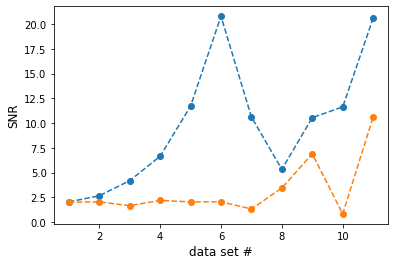

In [23]:
plt.plot(np.arange(1, len(B1s)+1), np.sqrt(B1s**2+B2s**2)/A1_errs, linestyle = '--', marker = 'o')
plt.plot(np.arange(1, len(C1s)+1), np.sqrt(C1s**2+C2s**2)/A2_errs, linestyle = '--', marker = 'o')
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('SNR', fontsize = 12)

# 3) Profile out the other signals and redo part 1. 



### Substituting in optimal parameters

A simple way to profile out the other signals is to simply substitute in the optimal values we have found. I substitute the optimal parameters found using the matrix method into the scipy.optimize.minimize method. Similar results are yielded to Problems 1 and 2.

In [24]:
periods = 2*np.pi/np.vstack(peak_omegas_list)

In [25]:
#select 3,4,5,8,9,10 as signals with ~100 day periods. use 100.49475059 as omega
#make model 3: 1 100 day signal, 1 non-100 day signal
#profile out the non-100 day signal

In [26]:
wh = np.where(np.around(periods) == 100)

In [27]:
omegas_100 = np.vstack(peak_omegas_list)[wh[0],:]

In [28]:
def model2_fit_noerror(data_xs, data_ys, data_sigma_ys, omegas):
    omega1, omega2 = omegas
    X = np.vstack((np.cos(omega1*data_xs), np.sin(omega1*data_xs), np.cos(omega2*data_xs), np.sin(omega2*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)
    
    #unpack data
    A1 = Z[0][0] 
    A2 = Z[1][0]
    B1 = Z[2][0]
    B2 = Z[3][0]
    return A1, A2, B1, B2

In [29]:
def log_likelihood_profiled(params,  C_inv = 1/yerrs**2, xs = xs, ys=ys, omegas = [1,1], opt_params = [1,1]):
    params_list = [*params,*opt_params]
    yhats = model2(xs, *params_list, *omegas)
    residuals = (ys-yhats)
    arr = -0.5*C_inv**2*residuals**2
    ll = np.sum(arr)
    return -ll    

In [30]:
def minimize_fit2_profiled(yerrs, xs, ys, omegas, opt_params):
    initParams = [1,1]
    ftol = 2.220446049250313e-09
    results = minimize(log_likelihood_profiled, initParams, method='L-BFGS-B', \
                   args = (1/yerrs**2, xs, ys, omegas, opt_params), \
                       bounds = [(0, None),(0, None)], tol = ftol)
    tmp_i = np.zeros(len(results.x))
    uncertainties = []
    for i in range(len(results.x)):
        tmp_i[i] = 1.0
        hess_inv_i = results.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(results.fun)) * ftol * hess_inv_i)
        tmp_i[i] = 0.0
        uncertainties.append(uncertainty_i)
    return results.x, np.array(uncertainties)

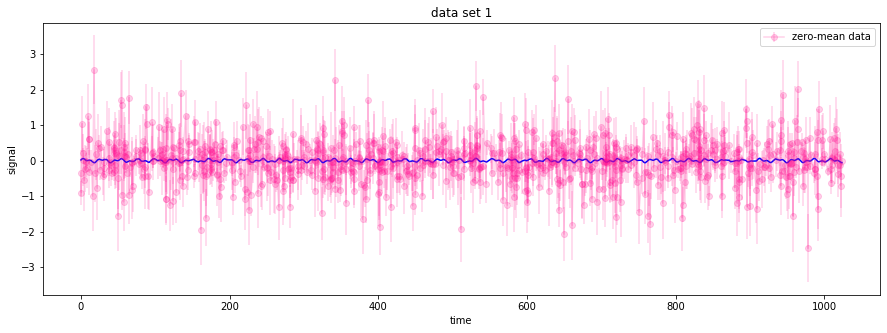

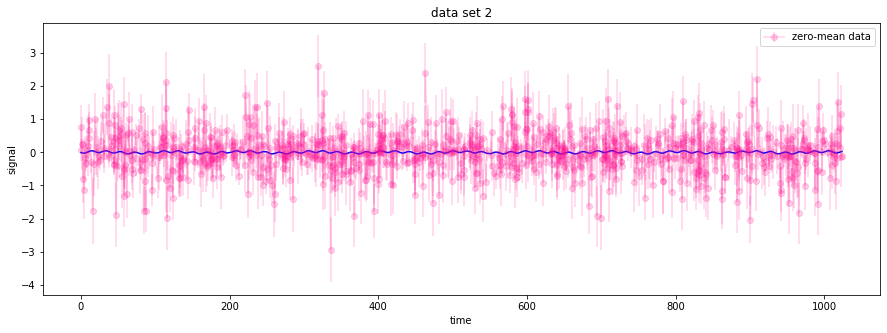

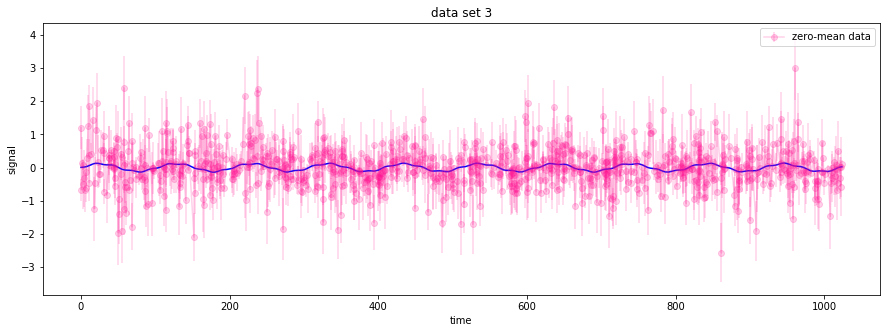

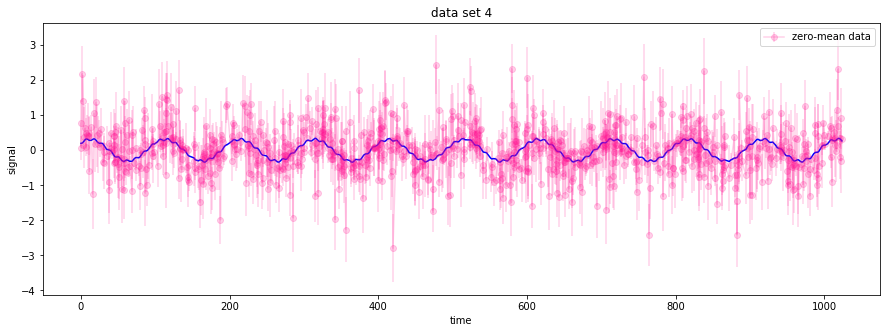

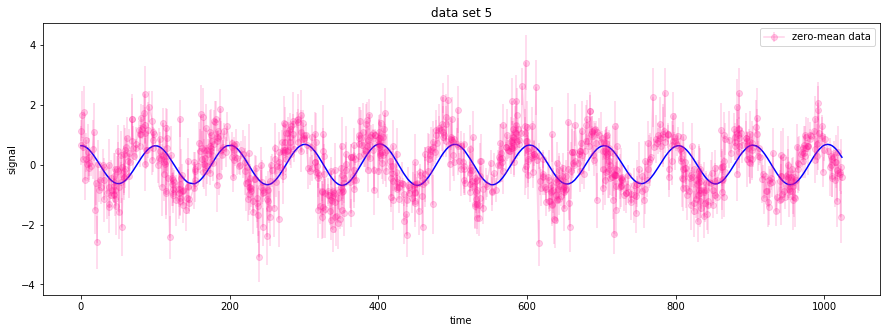

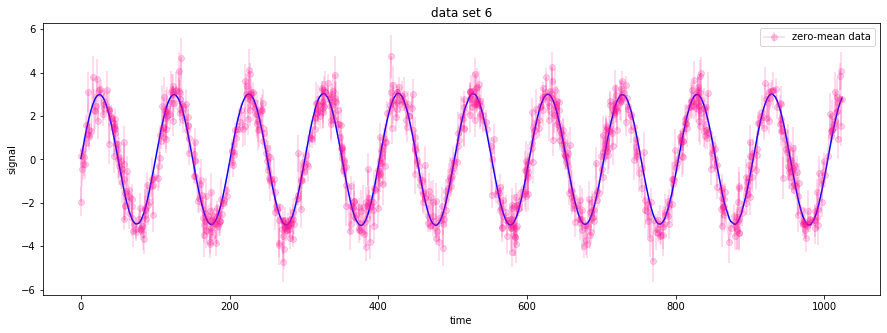

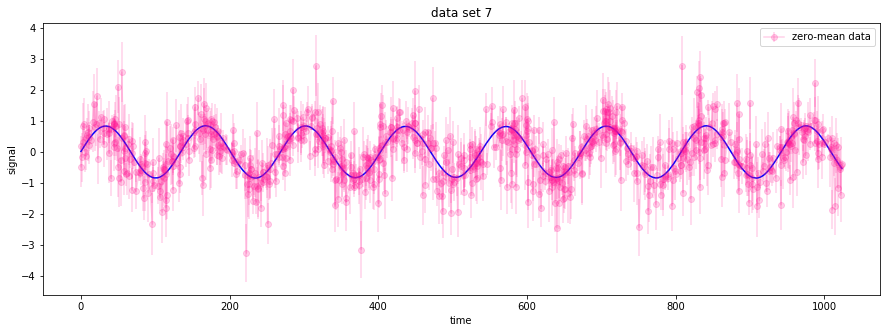

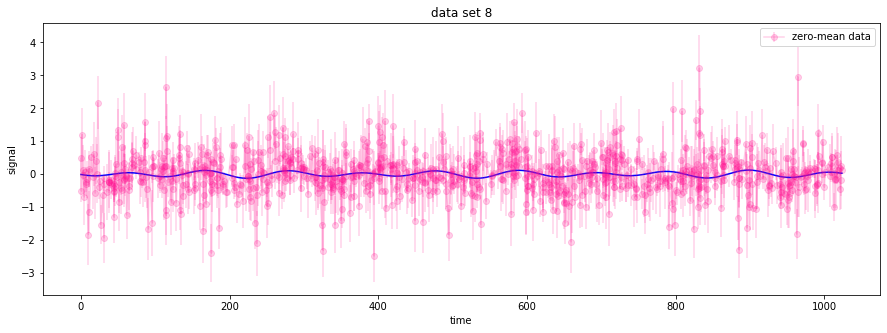

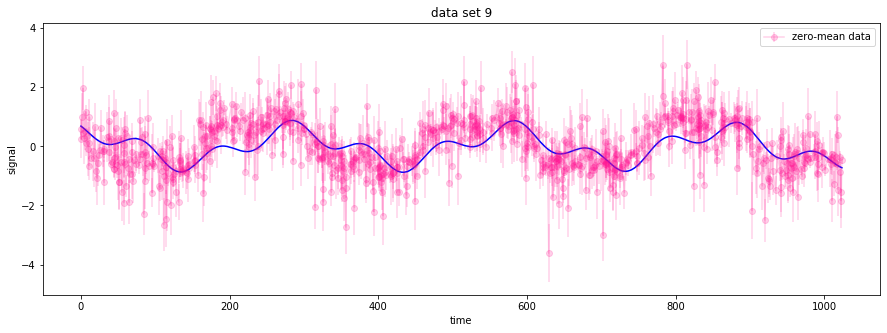

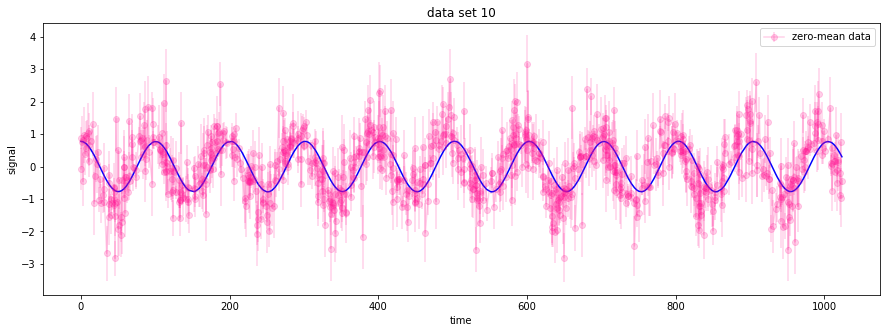

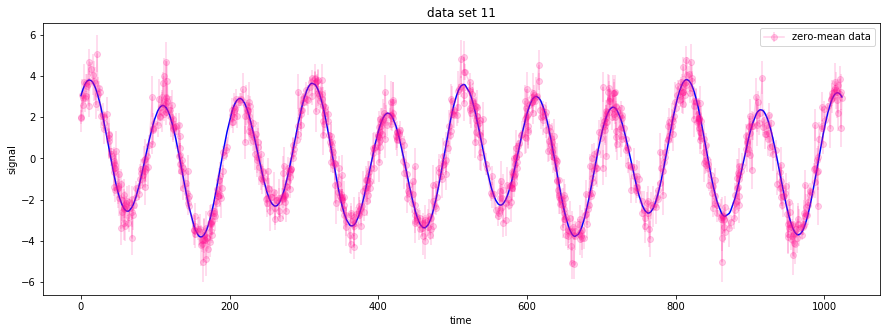

In [31]:
xs = data[0]
yerrs = data[1]

params_list = []
errors_list = []

for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    ys = data[i]-np.mean(data[i])
    omegas = (peak_omegas_list[i-2]).tolist()
    opt_params = model2_fit_noerror(xs, ys, yerrs, omegas)[2:]
    
    params, errors = minimize_fit2_profiled(yerrs, xs, ys, omegas, opt_params)
    plist = [*params, *opt_params]
    plt.errorbar(xs, ys, yerr=yerrs,
                 color="deeppink", marker="o", alpha=0.2, label = 'zero-mean data')
    plt.plot(xs, model2(xs,*plist,*omegas), color = 'blue')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.legend()
    plt.title("data set {}".format(i-1))
    params_list.append(params)
    errors_list.append(errors)

In [32]:
params_arr = np.vstack(params_list)
errors_arr = np.vstack(errors_list)
A1s = np.sqrt(params_arr[:,0]**2+params_arr[:,1])
A1_errs = calc_error(params_arr[:,0], params_arr[:,1], errors_arr[:,0], errors_arr[:,1])

In [33]:
#print the different signal periods. check the signal strength in the SNR plot below.
2*np.pi/np.vstack(peak_omegas_list)

array([[ 23.91747493,  10.58321046],
       [ 97.40692306,  19.44336686],
       [102.11326048,  24.37726561],
       [100.49475059,  11.00573724],
       [100.49475059, 117.2157259 ],
       [100.49475059, 117.2157259 ],
       [134.63968515, 113.03623486],
       [150.63360024, 103.78475731],
       [287.00969922, 100.49475059],
       [100.49475059, 150.63360024],
       [100.49475059, 263.1824789 ]])

Text(0, 0.5, 'Signal amplitude')

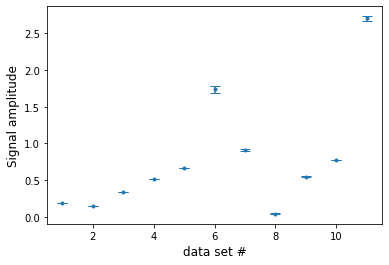

In [34]:
#C1 = Asin(phi)
#C2 = Acos(phi)
#A = np.sqrt(C1**2+C2**2)
#error_A = propogate the error!
plt.errorbar(np.arange(1, len(A1s)+1), A1s, yerr = A1_errs, \
             linestyle = 'none', marker = 'o', markersize = 3,\
             capsize = 5)

plt.xlabel('data set #', fontsize = 12)
plt.ylabel('Signal amplitude', fontsize = 12)

Text(0, 0.5, 'Signal SNR')

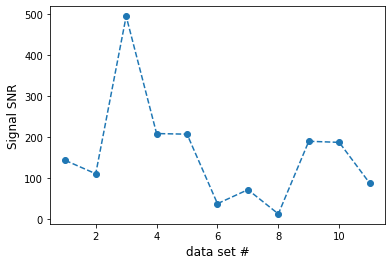

In [35]:
plt.plot(np.arange(1, len(A1s)+1), A1s/A1_errs, linestyle = '--', marker = 'o')
plt.xlabel('data set #', fontsize = 12)
plt.ylabel('Signal SNR', fontsize = 12)

### Using the Frisch–Waugh–Lovell theorem: WARNING:BUGS!

The idea here is to profile out the "nuisance" variables $B_1$ and $B_2$ in $y(x) =  A_1\cos(\omega_1x)+A_2\sin(\omega_1x)+B_1\cos(\omega_2x)+B_2\sin(\omega_2x)$. We do this by the Frisch–Waugh–Lovell theorem:

$\hat {\beta }_{1}=\left(\mathbf {X} _{1}^{\mathsf {T}}\left(\mathbf {I} -\mathbf {P} _{2}\right)\mathbf {X} _{1}\right)^{-1}\mathbf {X} _{1}^{\mathsf {T}}\left(\mathbf {I} -\mathbf {P} _{2}\right)\mathbf {y}$ 

See https://en.wikipedia.org/wiki/Likelihood_function#Likelihoods_that_eliminate_nuisance_parameters 

I implement this below, but there is a problem: to get the correct fits I had to change $\beta_1$ to $\beta_2$ in the above equation! There are bugs here that need to be fixed!

In [36]:
# doing it the matrix way:

def model2_fit_profiled(data_xs, data_ys, omegas):
    
    if np.around(omegas[0])==100:
        omega1, omega2 = omegas
    else:
        omega2, omega1 = omegas
    
    X2 = np.vstack((np.cos(omega1*data_xs), np.sin(omega1*data_xs))).T #parameters we care about
    X1 = np.vstack((np.cos(omega2*data_xs), np.sin(omega2*data_xs))).T #parameter we don't care about
    Y = np.expand_dims(data_ys, 1)
    #P1 = X1@np.linalg.inv(X1.T@X1)@X1.T
    P2 = X2@np.linalg.inv(X2.T@X2)@X2.T
    #I_P1 = np.identity(P1.shape[0])-P1
    I_P2 = np.identity(P2.shape[0])-P2
    A = X1.T@I_P2@X1
    B = X1.T@I_P2@Y
    
    #solve AZ=B for Z
    Z = linalg.solve(A, B)

    #unpack data
    A1 = Z[0][0]
    A2 = Z[1][0]

    return A1, A2

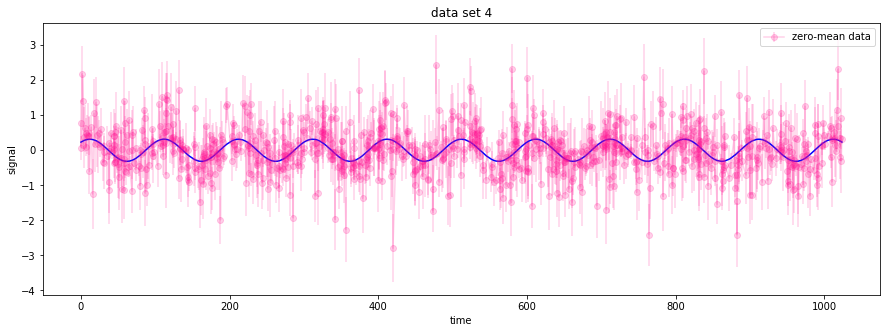

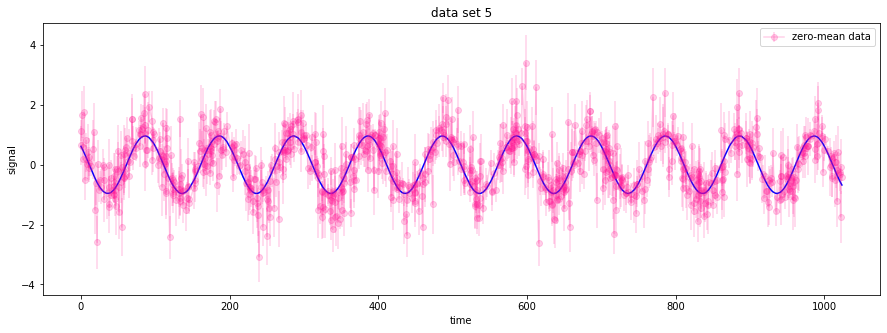

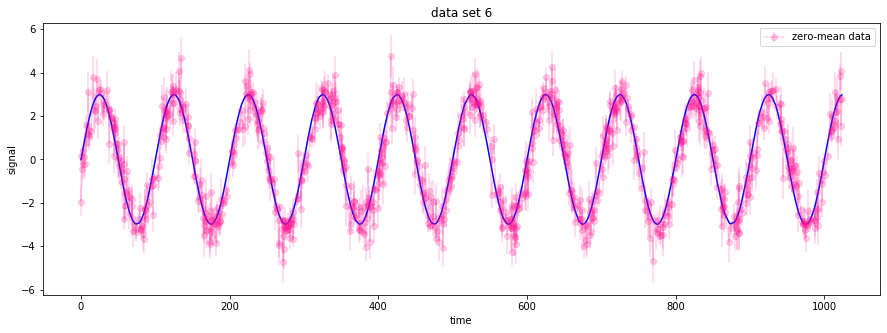

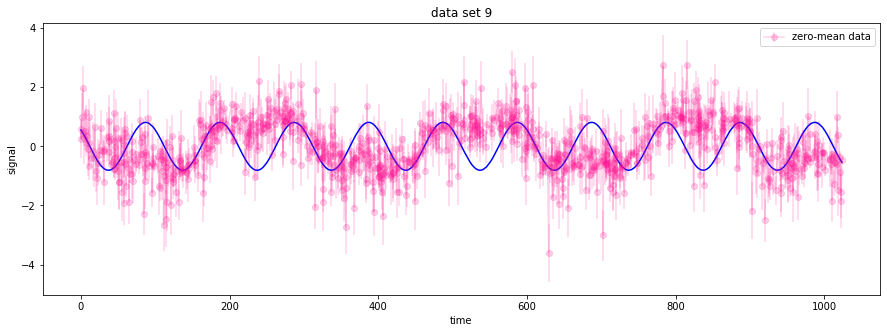

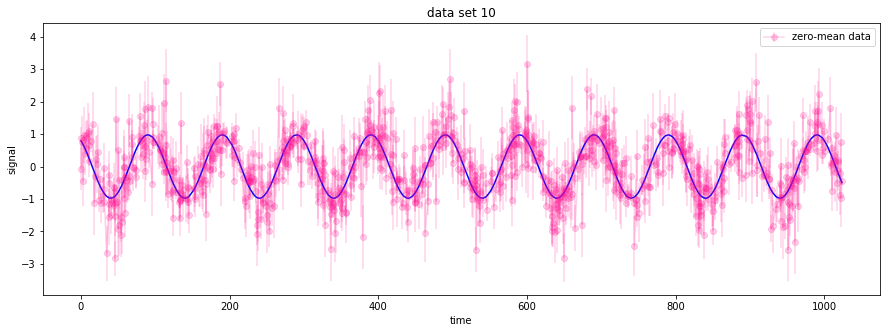

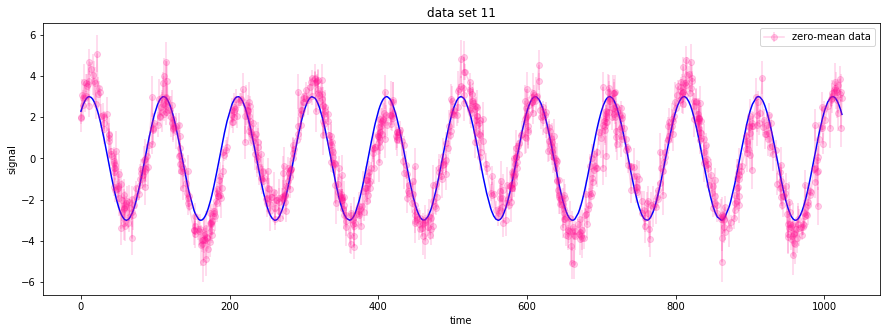

In [37]:
for i in range(len(omegas_100)):
    plt.figure(figsize=(15, 5))
    index=wh[0][i]
    ys = data[index+2]-np.mean(data[index+2])
    omegas = omegas_100[i]
    A1, A2 = model2_fit_profiled(xs, ys, omegas)
    plt.errorbar(data[0], ys, yerr=data[1],
                 color="deeppink", marker="o", alpha=0.2, label = 'zero-mean data')
    plt.plot(xs, model1(xs, A1, A2), color = 'blue')
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.legend()
    plt.title("data set {}".format(index+2-1))

# Other: Profiling and confidence intervals: WARNING:BUGS!

See https://math.mcmaster.ca/~bolker/emdbook/chap6A.pdf for more details. The idea here is that we want a confidence interval for our parameters. 

A quote from the above text,  Bolker, Ecological Models and Data in R:


" Likelihood Ratio Test (LRT). Take some likelihood function $\mathcal{L}(p_1, p_2, . . . , p_n)$, and find the
overall best (maximum likelihood) value, $\mathcal{L}_{abs} = \mathcal{L}(\hat{p}_1, \hat{p}_2, . . . \hat{p}_n)$ (“abs” stands for “absolute”). Now fix some of the parameters (say $p_1 . . . p_r$ ) to specific val-
ues ($p^∗_1, . . . p^∗_r$ ), and maximize with respect to the remaining parameters to get
$\mathcal{L}_{restr} = \mathcal{L}(p^∗_1, . . . , p^∗_r , \hat{p}_{r+1}, . . . , \hat{p}_n)$ (“restr” stands for “restricted”, sometimes also called a reduced or nested model). The Likelihood Ratio Test says that the
distribution of twice the negative log of the likelihood ratio, $−2 \log(\mathcal{L}_{restr}/\mathcal{L}_{abs})$,
called the deviance, is approximately χ2 (“chi-squared”) distribution "

From https://en.wikipedia.org/wiki/Likelihood_function#Likelihoods_that_eliminate_nuisance_parameters ,
we know  

$\beta _{2}(\beta _{1})=\left(\mathbf {X} _{2}^{\mathsf {T}}\mathbf {X} _{2}\right)^{-1}\mathbf {X} _{2}^{\mathsf {T}}\left(\mathbf {y} -\mathbf {X} _{1}\beta _{1}\right)$

where $\beta_1$ are parameters we specify, and $\beta_2$ are the optimal parameters that maximize the log likelihood function given our choice of $\beta_1$. The design matrix $\mathbf {X} _{2}$ corresponds to parameters $\beta_2$ while the design matrix $\mathbf {X} _{1}$ corresponds to parameters $\beta_1$.

In the below code, I again use the model

$y(x) =  A_1\cos(\omega_1x)+A_2\sin(\omega_1x)+B_1\cos(\omega_2x)+B_2\sin(\omega_2x)$

and choose to sweep over values of $A_1$ while allowing the other parameters to vary while maximizing the log likelihood. I plug these parameters into the negative log likelihood function and subtract off the "true" negative log likelihood (calculated from the optimal parameters). I do this procedure on data set 11 only.

In the resulting $\Delta \mathcal{L}$ vs. $A_1$ plot, you can see that the "true" $A_1$ value is close to the minimum. However, the minimum $\Delta \mathcal{L}$ should be close to 0, and it's not! 

This is due to the following: There's an issue with this code where it find_profile_params returns $\{B_2, A_1, A_2\}$ instead of the desired $\{A_2, B_1, B_2\}$. I'm not sure what went wrong in find_profile_params! 

In [38]:
#how do I find the error on my parameters? Use profiling: compute the log likelihood for the optimal parameters
#as the "true" log likelihood. Then fix the parameter of interest at a certain value, and compute the 
# optimal other parameters and plug into the log likelihood function

#for a given b1, we know b2. just plug b2 into the log likelihood function and subtract from the "True"

In [39]:
def NLL(data_xs, data_ys, data_sigma_ys, omegas, params):
    omega1, omega2 = omegas
    X = np.vstack((np.cos(omega1*data_xs), np.sin(omega1*data_xs), np.cos(omega2*data_xs),\
                   np.sin(omega2*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    Z = np.expand_dims(np.array(params),1)
    A = Y-X@Z
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    const = np.sum(np.log(np.sqrt(1/(2*np.pi*data_sigma_ys**2))))
    return -(-0.5*A.T@C_inv@A+const)[0][0]

In [40]:
def find_profile_params(data_xs, data_ys, omegas, param):
    if np.around(omegas[0])==100:
        omega1, omega2 = omegas
    else:
        omega2, omega1 = omegas
    X1 = np.expand_dims(np.cos(omega1*data_xs),1) #parameters we care about
    z1 = param
    X2 = np.vstack((np.sin(omega1*data_xs), np.cos(omega2*data_xs), np.sin(omega2*data_xs))).T 
    Y = np.expand_dims(data_ys, 1)
    B = np.linalg.inv(X2.T@X2)
    A = Y-X1*z1
    Z2 = B@X2.T@A
    return Z2    
    

In [41]:
def find_profile_NLL(data_xs, data_ys, data_sigma_ys, omegas, param):
    profile_params = find_profile_params(data_xs, data_ys, omegas, param)
    params = [param, *profile_params]
    profile_NLL = NLL(data_xs, data_ys, data_sigma_ys, omegas, params)
    return profile_NLL

In [42]:
# Choose to sweep over parameter A1 in model 2: y = A1*np.cos(omega1*x)+A2*np.sin(omega1*x)+B1*np.cos(omega2*x)+\
#            B2*np.sin(omega2*x)
i=5
omegas = omegas_100[i]
index=wh[0][i]
ys = data[index+2]-np.mean(data[index+2])

In [43]:
params = model2_fit_noerror(xs, ys, yerrs, omegas)
true_NLL = NLL(xs, ys, yerrs, omegas, params)
B1_test = np.linspace(2, 3, 20)
curve = [find_profile_NLL(xs, ys, yerrs, omegas, B1)-true_NLL for B1 in B1_test]

/home/mia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [44]:
#below is an example of the bug: we're not getting the desired parameter values from find_profile_params
find_profile_params(xs, ys, omegas, 2)

array([[0.33593376],
       [2.22632286],
       [1.89006523]])

In [45]:
params

(2.3023632135432095,
 1.9480331137892084,
 0.7148713933635177,
 0.38978307695304615)

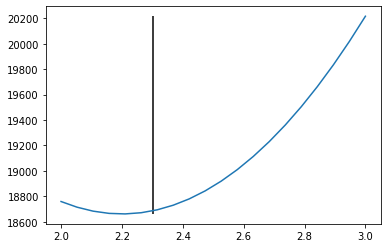

In [46]:
plt.plot(B1_test, curve)
plt.vlines(params[0], np.min(curve), np.max(curve))